<a href="https://colab.research.google.com/github/csch7/CSCI-4170/blob/main/Homework-06/Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://paperswithcode.com/dataset/xl-sum

In [1]:
!pip install datasets

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from transformers import BartTokenizer, BartForConditionalGeneration
from datasets import load_dataset

from google.colab import drive

dat = load_dataset('csebuetnlp/xlsum', 'english')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
train = dat['train'].to_pandas()
test = dat['test'].to_pandas()

print(train.shape, test.shape)

(306522, 5) (11535, 5)


In [4]:
print(train.head())

                                       id  \
0                       uk-wales-56321577   
1  uk-scotland-highlands-islands-11069985   
2               uk-england-leeds-45776523   
3                world-us-canada-51010441   
4       uk-scotland-glasgow-west-52274685   

                                                 url  \
0         https://www.bbc.com/news/uk-wales-56321577   
1  https://www.bbc.com/news/uk-scotland-highlands...   
2  https://www.bbc.com/news/uk-england-leeds-4577...   
3  https://www.bbc.com/news/world-us-canada-51010441   
4  https://www.bbc.com/news/uk-scotland-glasgow-w...   

                                               title  \
0  Weather alert issued for gale force winds in W...   
1   Huge tidal turbine installed at Orkney test site   
2  Leeds stabbing: Man attacked outside betting shop   
3  Could killing of Iranian general help Trump ge...   
4  Coronavirus: 'I've moved out to protect my fam...   

                                             summary  \

In [5]:
train = train.drop(columns=['id', 'url', 'title'])
test = test.drop(columns=['id', 'url', 'title'])


In [6]:
print(train.head(), test.head())

                                             summary  \
0  Winds could reach gale force in Wales with sto...   
1  The massive tidal turbine AK1000 has been inst...   
2  A man has been stabbed in broad daylight outsi...   
3  It was inevitable that the fallout from the US...   
4  Week four of social distancing is starting to ...   

                                                text  
0  The Met Office has issued a yellow weather war...  
1  Atlantis Resources unveiled the marine energy ...  
2  Police were called to the scene outside the Co...  
3  Anthony ZurcherNorth America reporter@awzurche...  
4  By Debbie JacksonBBC Scotland But while most o...                                                summary  \
0  Donald Trump campaigned on becoming a presiden...   
1  The Welsh Government "would probably" take the...   
2  A university has mistakenly emailed hundreds o...   
3  Some progress has been made in encouraging gir...   
4  The president of business organisation, the CB... 

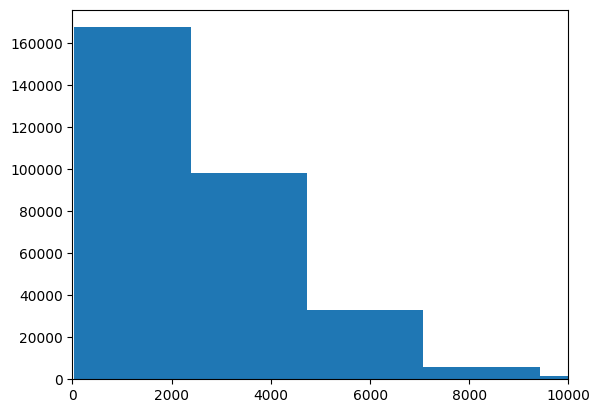

In [7]:
plt.hist([len(t) for t in train.text], bins=100)
plt.xlim(0, 10000)
plt.show()

In [11]:
train = train.sample(frac=1).reset_index(drop=True)
train = train[:30000]

train = train[train['text'].apply(lambda x: len(x.split(" ")) <= 2000)]
test = test[test['text'].apply(lambda x: len(x.split(" ")) <= 2000)]

train = train.sample(90).reset_index(drop=True)
test = test.sample(10).reset_index(drop=True)

In [12]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

In [13]:
import torch
from tqdm import tqdm

# encoded_articles = []
# encoded_summaries = []

# # for i in tqdm(range(10000), total=10000):
# encoded_articles = tokenizer(list(train.text), padding = 'longest')
# # print(len(encoded_articles[-1]['input_ids']))
# encoded_summaries = tokenizer(text_target = list(train.summary), padding = 'longest')


In [16]:
from torch import optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

def train_Bart(data, labels, model, tokenizer, batch_size = 1, epochs = 20, lr = 0.001):

  model.train()
  optimizer = optim.AdamW(model.parameters(), lr)

  for e in range(epochs):
    losses = []
    # train_loader = iter(train_l)
    i = 0
    for b in range(np.shape(data)[0]//batch_size):
      optimizer.zero_grad()
      d = data[b*batch_size : (b+1)*batch_size]
      t = labels[b*batch_size : (b+1)*batch_size]
      batch = tokenizer(d, padding = 'longest', max_length = 1024, truncation = True)
      attn = torch.LongTensor(batch['attention_mask'])
      batch = torch.LongTensor(batch['input_ids'])
      tar = torch.LongTensor(tokenizer(text_target = t, max_length = 1024, padding = 'longest', truncation = True)['input_ids'])
      model_output = model(batch, attn, labels = tar)
      loss = model_output.loss
      losses.append(loss.item())
      loss.backward()
      optimizer.step()
      i+=1
    print("Epoch {} | Loss {:.5f}".format(e, np.mean(losses)))

train_Bart(list(train.text), list(train.summary), model, tokenizer)

90
Epoch 0 | Loss 9.35428
Epoch 1 | Loss 7.07859
Epoch 2 | Loss 6.75079
Epoch 3 | Loss 6.65174
Epoch 4 | Loss 6.43700
Epoch 5 | Loss 6.39476
Epoch 6 | Loss 6.36023
Epoch 7 | Loss 6.24917
Epoch 8 | Loss 6.20183
Epoch 9 | Loss 6.30769
Epoch 10 | Loss 6.16971
Epoch 11 | Loss 6.11458
Epoch 12 | Loss 6.16380
Epoch 13 | Loss 6.08092
Epoch 14 | Loss 6.19205
Epoch 15 | Loss 6.03631
Epoch 16 | Loss 6.07624
Epoch 17 | Loss 5.99826
Epoch 18 | Loss 6.16777
Epoch 19 | Loss 6.21521


In [ ]:
model.eval()
with torch.no_grad():
  for b in range(10):
    d = list(test.text)[b*batch_size : (b+1)*batch_size]
    t = list(test.summary)[b*batch_size : (b+1)*batch_size]
    batch = tokenizer(d, padding = 'longest', max_length = 1024, truncation = True)
    attn = torch.LongTensor(batch['attention_mask'])
    batch = torch.LongTensor(batch['input_ids'])
    model_output = model(batch, attn)
    pred = model_output.logits

